# EDA: IMDB Movie Features
In this notebook, we analyze the distribution of our engineered popular features accross the 9k movies in our dataset. 
Naturally, we find runtime, release decade, and genre to be the most popular features. We then plot the distribution of features by category.

In [1]:
import pickle
import pandas as pd
import altair as alt
from collections import Counter
import re
import os
import pickle
import pandas as pd
import altair as alt
import numpy as np
from collections import Counter, defaultdict


DATA_PATH = "../data"
NETFLIX_FOLDER_PATH = os.path.join(DATA_PATH, "netflix_prize")
IMDB_FOLDER_PATH = os.path.join(DATA_PATH, "imdb")
MIN_OCCURRENCES = 20

## Analyse Feature Frequencies

In [2]:
def load_data(data_path, min_occurrences):
    """Load the feature mapping and movie features data."""
    # Load feature mappings
    with open(f'{data_path}/processed/feature_mapping_{min_occurrences}.pickle', 'rb') as f:
        feature_mapping = pickle.load(f)
    
    # Load movie features
    with open(f'{data_path}/processed/movie_features_{min_occurrences}.pickle', 'rb') as f:
        movie_features = pickle.load(f)
    
    return feature_mapping, movie_features

def calculate_feature_frequencies(movie_features, feature_mapping):
    """Calculate frequency of each feature across all movies."""
    # Flatten all feature IDs
    all_features = [feat for feats in movie_features.values() for feat in feats]
    
    # Count frequencies
    feature_counts = Counter(all_features)
    
    # Create DataFrame with feature details
    feature_freq_df = pd.DataFrame([
        {
            'feature_id': feat_id,
            'feature_name': feature_mapping['id_to_feature'][feat_id],
            'frequency': count
        }
        for feat_id, count in feature_counts.items()
    ])
    
    # Add feature category
    feature_freq_df['category'] = feature_freq_df['feature_name'].apply(
        lambda x: x.split(':')[0] if ':' in x else 'Other'
    )
    
    return feature_freq_df

def plot_top_features(feature_freq_df, top_n=30):
    """Plot top N most frequent features."""
    chart = alt.Chart(
        feature_freq_df.nlargest(top_n, 'frequency')
    ).mark_bar().encode(
        x=alt.X('frequency:Q', title='Number of Movies'),
        y=alt.Y('feature_name:N', sort='-x', title='Feature'),
        color='category:N',
        tooltip=['feature_name', 'frequency', 'category']
    ).properties(
        title=f'Top {top_n} Most Frequent Features',
        width=800,
        height=500
    )
    
    return chart

def plot_category_distributions(feature_freq_df):
    """Plot feature frequency distributions by category."""
    # Calculate statistics per category
    category_stats = feature_freq_df.groupby('category').agg({
        'frequency': ['count', 'mean', 'median', 'max']
    }).reset_index()
    
    category_stats.columns = ['category', 'count', 'mean', 'median', 'max']
    
    # Create box plot
    box_plot = alt.Chart(feature_freq_df).mark_boxplot().encode(
        x=alt.X('frequency:Q', scale=alt.Scale(type='log'), title='Frequency (log scale)'),
        y=alt.Y('category:N', title='Feature Category'),
        color='category:N',
        tooltip=['category', 'frequency']
    ).properties(
        title='Feature Frequency Distribution by Category',
        width=800,
        height=400
    )
    
    return box_plot

def analyze_specific_roles(feature_freq_df, role, top_n=20):
    """Analyze top contributors for specific roles (Writer/Director/Composer)."""
    role_features = feature_freq_df[feature_freq_df['feature_name'].str.startswith(f'{role}:')]
    
    # Create bar chart for top contributors
    chart = alt.Chart(
        role_features.nlargest(top_n, 'frequency')
    ).mark_bar().encode(
        x=alt.X('frequency:Q', title='Number of Movies'),
        y=alt.Y(
            'feature_name:N', 
            sort='-x', 
            title=f'Top {role}s',
            axis=alt.Axis(labelLimit=200)  # Allow longer labels
        ),
        tooltip=['feature_name', 'frequency']
    ).properties(
        title=f'Top {top_n} Most Frequent {role}s',
        width=800,
        height=500
    )
    
    return chart

# Function to run all analyses
def run_analysis(data_path, min_occurrences):
    """Run complete feature frequency analysis."""
    # Load data
    feature_mapping, movie_features = load_data(data_path, min_occurrences)
    
    # Calculate frequencies
    feature_freq_df = calculate_feature_frequencies(movie_features, feature_mapping)
    
    # Generate plots
    top_features_plot = plot_top_features(feature_freq_df)
    category_dist_plot = plot_category_distributions(feature_freq_df)
    
    # Analyze specific roles
    writer_plot = analyze_specific_roles(feature_freq_df, 'Writer')
    director_plot = analyze_specific_roles(feature_freq_df, 'Director')
    composer_plot = analyze_specific_roles(feature_freq_df, 'Composer')
    cast_plot = analyze_specific_roles(feature_freq_df, 'Cast')
    producer_plot = analyze_specific_roles(feature_freq_df, 'Producer')
    
    return {
        'feature_frequencies': feature_freq_df,
        'plots': {
            'top_features': top_features_plot,
            'category_distribution': category_dist_plot,
            'top_writers': writer_plot,
            'top_directors': director_plot,
            'top_composers': composer_plot,
            'top_cast': cast_plot,
            'top_producer': producer_plot,
        }
    }

In [3]:
results = run_analysis(DATA_PATH, MIN_OCCURRENCES)
feature_freq_df = results['feature_frequencies']

# Display plots
results['plots']['top_features'].show()
results['plots']['category_distribution'].show()
results['plots']['top_cast'].show()
results['plots']['top_directors'].show()
results['plots']['top_writers'].show()
results['plots']['top_composers'].show()
results['plots']['top_producer'].show()

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

## Analyse Movie-Feature Frequencies

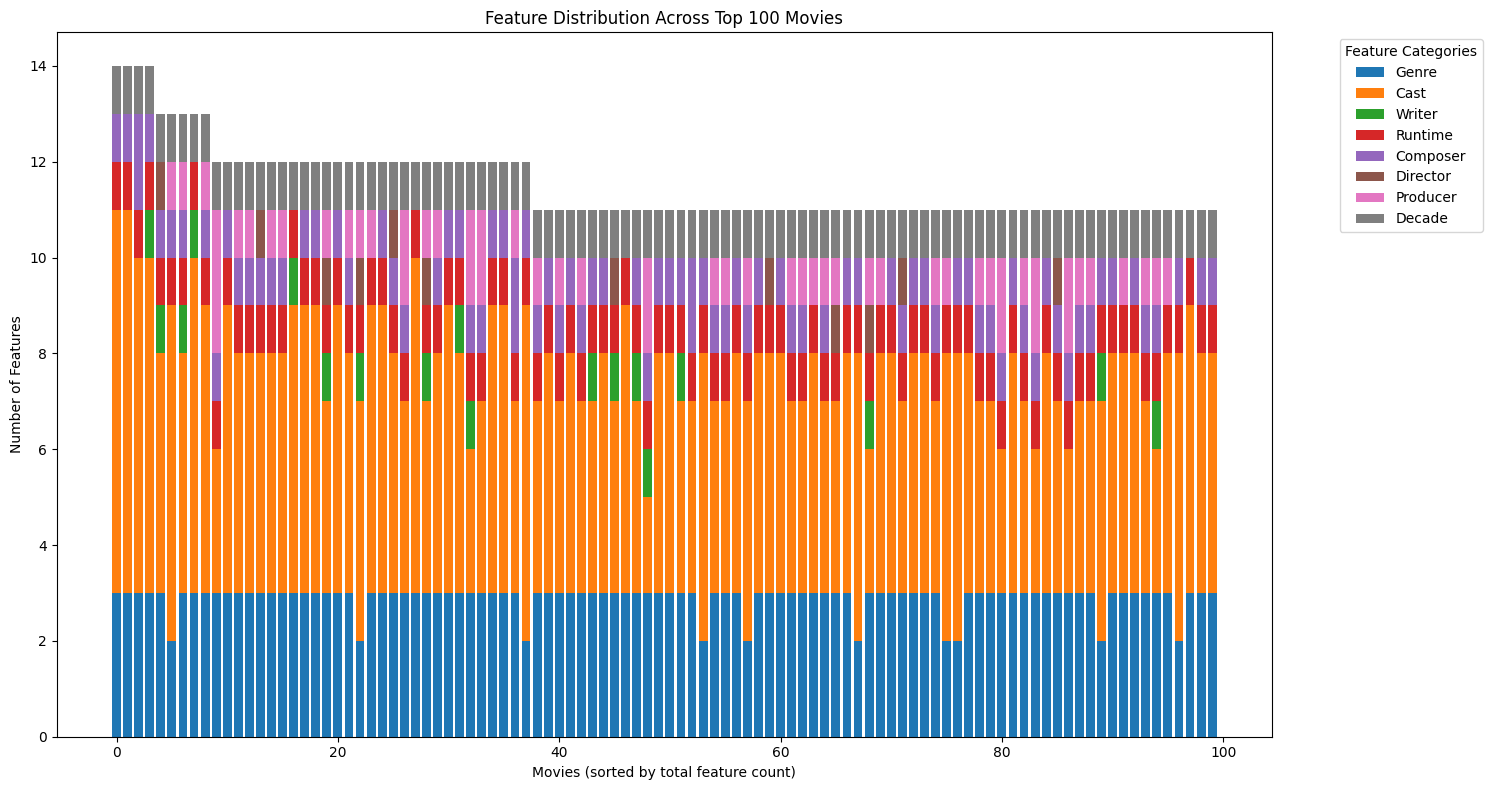

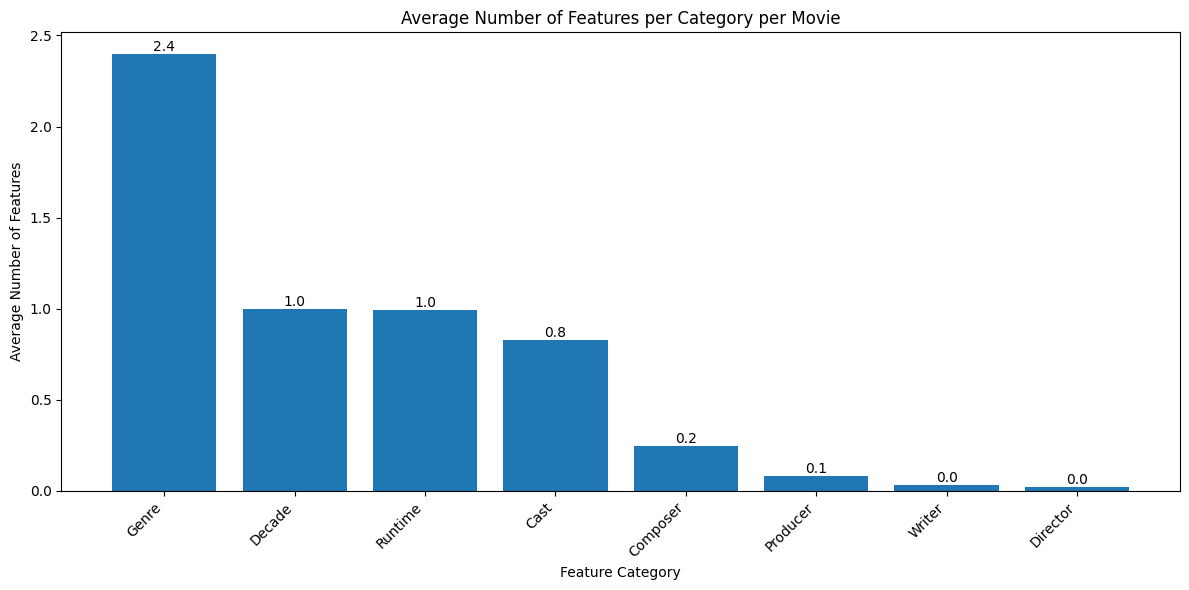


Total Statistics:
total_movies: 9443.00
avg_features_per_movie: 5.60
median_features_per_movie: 5.00
min_features: 1.00
max_features: 14.00

Category Statistics:
        Genre  Cast  Writer  Runtime  Composer  Director  Producer  Decade
mean      2.4  0.83    0.04      1.0      0.25      0.02      0.08     1.0
median    3.0  0.00    0.00      1.0      0.00      0.00      0.00     1.0
min       0.0  0.00    0.00      0.0      0.00      0.00      0.00     0.0
max       3.0  8.00    3.00      1.0      3.00      1.00      3.00     1.0


In [4]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

def load_data(data_path, min_occurrences):
    """Load the feature mapping and movie features data."""
    # Load feature mappings
    with open(f'{data_path}/processed/feature_mapping_{min_occurrences}.pickle', 'rb') as f:
        feature_mapping = pickle.load(f)
    
    # Load movie features
    with open(f'{data_path}/processed/movie_features_{min_occurrences}.pickle', 'rb') as f:
        movie_features = pickle.load(f)
    
    return feature_mapping, movie_features

def analyze_movie_features(movie_features, feature_mapping):
    """Analyze feature distribution across movies."""
    
    # Create dictionary to store features by category for each movie
    movie_features_by_category = defaultdict(lambda: defaultdict(list))
    
    # Process each movie's features
    for movie_id, feature_ids in movie_features.items():
        # Group features by category for this movie
        for feat_id in feature_ids:
            feature_name = feature_mapping['id_to_feature'][feat_id]
            category = feature_name.split(':')[0] if ':' in feature_name else 'Other'
            movie_features_by_category[movie_id][category].append(feat_id)
    
    # Convert to DataFrame format for visualization
    records = []
    for movie_id, categories in movie_features_by_category.items():
        record = {
            'movie_id': movie_id,
            'total_features': len(movie_features[movie_id])
        }
        # Add count for each category
        for category in set(cat for cats in movie_features_by_category.values() for cat in cats):
            record[f'{category}_count'] = len(categories.get(category, []))
        records.append(record)
    
    df = pd.DataFrame(records)
    
    return df

def plot_feature_distribution(df, top_n=100):
    """Create stacked bar chart showing feature distribution across top N movies."""
    
    # Get top N movies by total features
    top_movies = df.nlargest(top_n, 'total_features')
    
    # Get feature categories
    categories = [col for col in df.columns if col.endswith('_count')]
    category_names = [cat.replace('_count', '') for cat in categories]
    
    # Prepare data for stacking
    data = top_movies[categories].values.T
    
    # Create figure
    plt.figure(figsize=(15, 8))
    
    # Create stacked bar chart
    bottom = np.zeros(top_n)
    for i, cat_data in enumerate(data):
        plt.bar(range(top_n), cat_data, bottom=bottom, label=category_names[i])
        bottom += cat_data
    
    # Customize plot
    plt.title(f'Feature Distribution Across Top {top_n} Movies')
    plt.xlabel('Movies (sorted by total feature count)')
    plt.ylabel('Number of Features')
    plt.legend(title='Feature Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return plt.gcf()

def plot_category_averages(df):
    """Create bar chart showing average number of features per category."""
    
    # Calculate average features per category
    categories = [col for col in df.columns if col.endswith('_count')]
    category_means = df[categories].mean()
    category_names = [cat.replace('_count', '') for cat in categories]
    
    # Sort categories by mean value
    sorted_indices = np.argsort(category_means.values)[::-1]
    sorted_means = category_means.values[sorted_indices]
    sorted_names = [category_names[i] for i in sorted_indices]
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Create bar chart
    bars = plt.bar(range(len(sorted_names)), sorted_means)
    
    # Customize plot
    plt.title('Average Number of Features per Category per Movie')
    plt.xlabel('Feature Category')
    plt.ylabel('Average Number of Features')
    plt.xticks(range(len(sorted_names)), sorted_names, rotation=45, ha='right')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    
    return plt.gcf()

def create_summary_statistics(df):
    """Generate summary statistics for feature distributions."""
    
    # Calculate basic statistics for total features
    total_stats = {
        'total_movies': len(df),
        'avg_features_per_movie': df['total_features'].mean(),
        'median_features_per_movie': df['total_features'].median(),
        'min_features': df['total_features'].min(),
        'max_features': df['total_features'].max(),
    }
    
    # Calculate statistics per category
    categories = [col for col in df.columns if col.endswith('_count')]
    category_stats = df[categories].agg(['mean', 'median', 'min', 'max']).round(2)
    category_stats.columns = [col.replace('_count', '') for col in category_stats.columns]
    
    return total_stats, category_stats

def run_analysis(data_path, min_occurrences, top_n=100):
    """Run complete movie feature distribution analysis."""
    
    # Set style
    
    # Load data
    feature_mapping, movie_features = load_data(data_path, min_occurrences)
    
    # Analyze features
    df = analyze_movie_features(movie_features, feature_mapping)
    
    # Generate visualizations
    distribution_plot = plot_feature_distribution(df, top_n)
    category_averages_plot = plot_category_averages(df)
    
    # Generate summary statistics
    total_stats, category_stats = create_summary_statistics(df)
    
    return {
        'data': df,
        'plots': {
            'feature_distribution': distribution_plot,
            'category_averages': category_averages_plot
        },
        'statistics': {
            'total_stats': total_stats,
            'category_stats': category_stats
        }
    }

# Usage example:
results = run_analysis(DATA_PATH, MIN_OCCURRENCES, top_n=100)

# Display plots
plt.show()

# Print statistics
print("\nTotal Statistics:")
for key, value in results['statistics']['total_stats'].items():
    print(f"{key}: {value:.2f}")

print("\nCategory Statistics:")
print(results['statistics']['category_stats'])